# Example notebook
In this notebook we'll look at how to use t(s)SVDD in an anomaly detection task.

In [1]:
import pandas as pd
import numpy as np

First, let's get some data. We'll use the ECG200 data set from https://www.timeseriesclassification.com/. 

In [2]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

resp = urlopen('https://www.timeseriesclassification.com/Downloads/ECG200.zip')
zipfile = ZipFile(BytesIO(resp.read()))
train = pd.read_csv(zipfile.open('ECG200_TRAIN.txt'), header=None, delim_whitespace=True)
test = pd.read_csv(zipfile.open('ECG200_TEST.txt'), header=None, delim_whitespace=True)
df = pd.concat([train, test])

The data set consists of normal (+1) and anoamlous (-1) heart beat recordings.

In [3]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]
df.tail()

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
95,1.0,0.843834,2.564764,3.343127,2.591811,1.989914,0.441743,0.356408,1.283447,0.820812,...,-0.243969,-0.242760,-0.356488,-0.245672,-0.184878,-0.277344,-0.105103,-0.169774,-0.023764,0.258732
96,1.0,1.398472,2.874771,3.453428,2.897919,1.260043,0.173332,1.289293,1.470054,1.028398,...,-0.406242,-0.525755,-0.439422,-0.398495,-0.366739,-0.399198,-0.401109,-0.371077,-0.451180,-0.100215
97,-1.0,1.113685,1.275951,1.171770,1.554551,2.280557,2.636614,2.514625,2.363170,2.290844,...,0.484357,0.474087,0.323893,0.387200,0.575901,0.426197,0.077527,0.148549,0.479638,0.358700
98,-1.0,2.318208,2.139772,1.794243,2.344508,1.724400,0.431501,-0.464933,-0.542414,-0.830620,...,-0.099292,-0.239948,-0.065850,-0.090294,-0.234900,-0.032727,-0.102668,-0.064539,0.285008,0.470914
99,1.0,2.395329,3.283697,2.918598,2.279072,1.393210,0.592044,0.044003,0.110276,0.198213,...,-0.049051,-0.099085,0.027991,0.141353,0.085650,0.005304,0.149875,0.103510,0.072660,0.215942


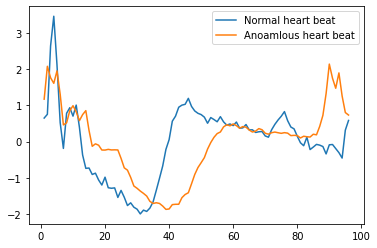

In [4]:
import matplotlib.pyplot as plt

plt.plot(X[df[0]==1].iloc[1], label='Normal heart beat')
plt.plot(X[df[0]==-1].iloc[2], label='Anoamlous heart beat')
plt.legend()
plt.show()

Let's create a training set with 80% of the normal data and add 5% outliers. We regard the reamining data as test data. 

In [5]:
NORMAL_RATIO = 0.8
OUTLIER_RATIO = 0.05
normal_index = y[y==1].index
outlier_index = y[y==-1].index
n_normal = int(len(normal_index) * NORMAL_RATIO)
n_outlier = int(n_normal / (1 - OUTLIER_RATIO)) - n_normal

rng = np.random.default_rng(42)
train_normal_index = pd.Int64Index(rng.choice(normal_index, n_normal, replace=False))
train_outlier_index = pd.Int64Index(rng.choice(outlier_index, n_outlier, replace=False))

train_index = train_normal_index.union(train_outlier_index)

test_normal_index = normal_index.drop(train_normal_index)  
test_outlier_index = outlier_index.drop(train_outlier_index)
test_index = test_normal_index.union(test_outlier_index)

X_train = X.iloc[train_index]
X_test = X.iloc[test_index]
y_train = y.iloc[train_index]
y_test = y.iloc[test_index]

Use tsvdd's SVDD as known from scikit-learn.

In [6]:
from tsvdd import SVDD
svdd = SVDD(nu=OUTLIER_RATIO)
svdd.fit(X_train)
y_pred = svdd.predict(X_train)

In [7]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_train, y_pred, labels=[+1, -1])  
conf_df = pd.DataFrame(conf_matrix, columns=[+1, -1], index=[1, -1])
conf_df

,1,-1
1,81,4
-1,20,3


Except for $C$ (internally determined by $\nu$), the Gaussian-like GA kernel has the $\sigma$ parameter. 

In [8]:
from tsvdd.utils import sampled_gak_sigma
sigmas = sampled_gak_sigma(X_train, X_train.shape[0])
param_grid = {"sigma": sigmas}

SVDD adopts scikit-learn's API and duck typing, thus we can use the usual hyperparameter methods such as a grid search.  

In [9]:
from sklearn.model_selection import GridSearchCV
search = GridSearchCV(SVDD(), param_grid, cv=[(slice(None), slice(None))], scoring='balanced_accuracy')
search = search.fit(X_train, y_train)

In [10]:
search.cv_results_

{'mean_fit_time': array([0.39157915, 0.38063741, 0.37757397, 0.37932491, 0.37794399]),
 'std_fit_time': array([0., 0., 0., 0., 0.]),
 'mean_score_time': array([0.00106835, 0.00097108, 0.00095081, 0.00107074, 0.00094724]),
 'std_score_time': array([0., 0., 0., 0., 0.]),
 'param_sigma': masked_array(data=[0.3662533974854092, 3.6625339748540915,
                    7.325067949708183, 18.31266987427046,
                    36.62533974854092],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'sigma': 0.3662533974854092},
  {'sigma': 3.6625339748540915},
  {'sigma': 7.325067949708183},
  {'sigma': 18.31266987427046},
  {'sigma': 36.62533974854092}],
 'split0_test_score': array([0.5173913 , 0.68030691, 0.64040921, 0.56930946, 0.54757033]),
 'mean_test_score': array([0.5173913 , 0.68030691, 0.64040921, 0.56930946, 0.54757033]),
 'std_test_score': array([0., 0., 0., 0., 0.]),
 'rank_test_score': array([5, 1, 2, 3, 4], dtype

In [11]:
y_pred = search.best_estimator_.predict(X_train)
conf_matrix = confusion_matrix(y_train, y_pred, labels=[+1, -1])  
conf_df = pd.DataFrame(conf_matrix, columns=[+1, -1], index=[1, -1])
conf_df

,1,-1
1,75,10
-1,12,11


Although, SVDD beeing an unsupervised method, it provides a predict function.

In [12]:
y_pred = search.best_estimator_.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred, labels=[+1, -1])  
conf_df = pd.DataFrame(conf_matrix, columns=[+1, -1], index=[1, -1])
conf_df

,1,-1
1,21,6
-1,13,22
